<div style="background-color: #d1a8ed; color: black; border: 5px solid #9038b5; padding: 10px;">
  <h1>sketch2clipart</h1>
  Generate clipart from simple sketches.   
  Data comes from the 
  <a href="https://www.kaggle.com/datasets/vishesh1211/clipart?resource=download-directory" target="_blank" style="color: blue;">Kaggle Clipart Dataset</a>. 
  Here are the 
  <a href="https://github.com/USFCA-MSDS/MSDS-631-GenAI" target="_blank" style="color: blue;">project instructions</a>.
</div>


<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Imports & Functions</h1>
</div>

In [1]:
import os
from tqdm import tqdm
import re

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import cv2
from PIL import Image

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Data Preprocessing</h1>
</div>

# Generate Data

Since we are building a model that generates cliparts from simple sketches as input, we need sketches paired with cliparts for training. The [Kaggle Clipart Dataset](https://www.kaggle.com/datasets/vishesh1211/clipart?resource=download-directory) has many clipart images. They don't come with sketches, however, so we decided to generate them using the `cv2` library. 

Steps (run if data isn't already downloaded): 
1. Download data from Kaggle 
2. Make a directory in this project directory: `data/clipart`
2. Put all the images inside `clipart`
3. Name them `clipart1.jpg`, `clipart2.jpg`, etc. 
4. Make a directory in this project directory: `data/sketch`
5. Run the code below 

The code below will make our dataset complete. `sketch1` goes with `clipart1`, `sketch2` goes with `clipart2`, and so on. 

In [2]:
# path2clipart = 'data/clipart'
# clips = [clip for clip in os.listdir(path2clipart) if clip.endswith('jpg')]
# for clip in tqdm(clips): 
#     num = clip.split('clipart')[1].split('.')[0]

#     pic = cv2.imread(f'{path2clipart}/{clip}')
#     gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
#     edges = cv2.Canny(gray, 50, 150)

#     cv2.imwrite(f'data/sketch/sketch{num}.png', edges)

# print('Finished generating data!')

# View Data

In [3]:
def view_image(image_path):
    """
    Load and display an image using PIL and matplotlib.
    
    Parameters
    ----------
        - image_path (str): Path to the image file

    Returns
    -------
        - None, displays image

    """
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

class Sketch2ClipartDataset(Dataset):
    """
    Paired dataset for sketch-to-clipart translation.
    
    Parameters
    ----------
        - sketch_dir (str): Path to directory with sketch images
        - clipart_dir (str): Path to directory with clipart images
        - transform (callable, optional): Transform to apply to images

    """
    def __init__(self, sketch_dir, clipart_dir, transform=None):
        self.sketch_dir = sketch_dir
        self.clipart_dir = clipart_dir
        self.files = [f for f in os.listdir(sketch_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.files[idx])
        
        # Extract numeric part
        numeric_part = os.path.splitext(self.files[idx])[0].replace("sketch", "")
        clipart_filename = f"clipart{numeric_part}.jpg"
        clipart_path = os.path.join(self.clipart_dir, clipart_filename)
        
        sketch = Image.open(sketch_path).convert("RGB")
        clipart = Image.open(clipart_path).convert("RGB")
        
        if self.transform:
            sketch = self.transform(sketch)
            clipart = self.transform(clipart)
        
        return sketch, clipart


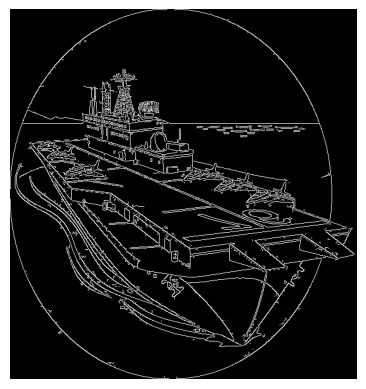

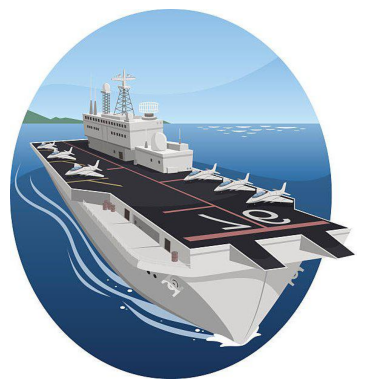

In [4]:
view_image("data/sketch/sketch1.png")
view_image("data/clipart/clipart1.jpg")

# Transform Data

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = Sketch2ClipartDataset("data/sketch", "data/clipart", transform=transform)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# For testing code on small subset of data 
subset = torch.utils.data.Subset(dataset, list(range(100))) 
dataloader = DataLoader(subset, batch_size=16, shuffle=True)

print(f"Dataset size: {len(dataset)} images")

Dataset size: 48833 images


<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Model Implementation</h1>
</div>

In [6]:
class UNetGenerator(nn.Module):
    """
    U-Net Generator for sketch-to-clipart translation.
    
    Parameters
    ----------
        - in_channels (int): Number of input channels 
        - out_channels (int): Number of output channels 

    """
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        self.down1 = self.conv_block(in_channels, 64)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        
        self.up1 = self.up_conv_block(512, 256)
        self.up2 = self.up_conv_block(512, 128)
        self.up3 = self.up_conv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)
        self.tanh = nn.Tanh()
    
    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    
    def up_conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        
        u1 = self.up1(d4)
        u1 = torch.cat([u1, d3], dim=1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, d2], dim=1)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, d1], dim=1)
        out = self.final(u3)
        return self.tanh(out)

class PatchDiscriminator(nn.Module):
    """
    PatchGAN Discriminator for sketch-to-clipart translation.
    
    Parameters
    ----------
        - in_channels (int): Number of input channels

    """
    def __init__(self, in_channels=6):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1),
            nn.Sigmoid()
        )
    
    def forward(self, sketch, clipart):
        x = torch.cat([sketch, clipart], dim=1)
        return self.model(x)

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Methods</h1>
</div>

In [7]:
# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = UNetGenerator().to(device)
discriminator = PatchDiscriminator().to(device)

# Losses and optimizers
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training
num_epochs = 50
g_losses = []
d_losses = []

for epoch in tqdm(range(num_epochs)):
    for i, (sketch, clipart) in enumerate(dataloader):
        sketch = sketch.to(device)
        clipart = clipart.to(device)
        generated_clipart = generator(sketch)
        generated_clipart = nn.functional.interpolate(
            generated_clipart, size=(256, 256), mode='bilinear', align_corners=False
        )
        d_output = discriminator(sketch, generated_clipart)

        # Make target tensors match discriminator output size
        valid = torch.ones_like(d_output).to(device)
        fake = torch.zeros_like(d_output).to(device)

        g_adv_loss = adversarial_loss(d_output, valid)

        g_l1_loss = l1_loss(generated_clipart, clipart)
        g_loss = g_adv_loss + 100 * g_l1_loss
        g_loss.backward()
        g_optimizer.step()

        # Discriminator
        d_optimizer.zero_grad()
        real_output = discriminator(sketch, clipart)
        fake_output = discriminator(sketch, generated_clipart.detach())
        d_real_loss = adversarial_loss(real_output, valid)
        d_fake_loss = adversarial_loss(fake_output, fake)
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")


  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch 0/50] [Batch 0] [D loss: 0.7305] [G loss: 87.7377]


  2%|▏         | 1/50 [00:17<14:30, 17.76s/it]

[Epoch 1/50] [Batch 0] [D loss: 0.5888] [G loss: 68.1799]


  4%|▍         | 2/50 [00:34<13:46, 17.22s/it]

[Epoch 2/50] [Batch 0] [D loss: 0.4799] [G loss: 71.8974]


  6%|▌         | 3/50 [00:52<13:33, 17.31s/it]

[Epoch 3/50] [Batch 0] [D loss: 0.3373] [G loss: 70.1955]


  8%|▊         | 4/50 [01:09<13:19, 17.38s/it]

[Epoch 4/50] [Batch 0] [D loss: 0.3012] [G loss: 59.0137]


 10%|█         | 5/50 [01:26<12:58, 17.29s/it]

[Epoch 5/50] [Batch 0] [D loss: 0.3340] [G loss: 70.2651]


 12%|█▏        | 6/50 [01:43<12:31, 17.08s/it]

[Epoch 6/50] [Batch 0] [D loss: 0.1893] [G loss: 49.6586]


 14%|█▍        | 7/50 [01:59<12:08, 16.95s/it]

[Epoch 7/50] [Batch 0] [D loss: 0.3532] [G loss: 50.2964]


 16%|█▌        | 8/50 [02:16<11:48, 16.87s/it]

[Epoch 8/50] [Batch 0] [D loss: 0.1374] [G loss: 41.2868]


 18%|█▊        | 9/50 [02:33<11:30, 16.84s/it]

[Epoch 9/50] [Batch 0] [D loss: 0.1149] [G loss: 41.0904]


 20%|██        | 10/50 [02:50<11:13, 16.83s/it]

[Epoch 10/50] [Batch 0] [D loss: 0.0957] [G loss: 48.8164]


 22%|██▏       | 11/50 [03:07<10:56, 16.82s/it]

[Epoch 11/50] [Batch 0] [D loss: 0.0752] [G loss: 62.0381]


 24%|██▍       | 12/50 [03:23<10:39, 16.83s/it]

[Epoch 12/50] [Batch 0] [D loss: 0.0647] [G loss: 46.5477]


 26%|██▌       | 13/50 [06:28<41:48, 67.79s/it]

[Epoch 13/50] [Batch 0] [D loss: 0.2720] [G loss: 47.4323]


 28%|██▊       | 14/50 [06:45<31:23, 52.31s/it]

[Epoch 14/50] [Batch 0] [D loss: 0.0764] [G loss: 47.8626]


 30%|███       | 15/50 [07:02<24:14, 41.55s/it]

[Epoch 15/50] [Batch 0] [D loss: 0.0557] [G loss: 38.6919]


 32%|███▏      | 16/50 [07:18<19:17, 34.05s/it]

[Epoch 16/50] [Batch 0] [D loss: 0.0469] [G loss: 44.8342]


 34%|███▍      | 17/50 [07:35<15:51, 28.82s/it]

[Epoch 17/50] [Batch 0] [D loss: 0.0372] [G loss: 44.3972]


 36%|███▌      | 18/50 [07:52<13:25, 25.19s/it]

[Epoch 18/50] [Batch 0] [D loss: 0.0319] [G loss: 40.2519]


 38%|███▊      | 19/50 [08:08<11:42, 22.66s/it]

[Epoch 19/50] [Batch 0] [D loss: 0.0299] [G loss: 44.4638]


 40%|████      | 20/50 [08:25<10:26, 20.89s/it]

[Epoch 20/50] [Batch 0] [D loss: 0.0210] [G loss: 58.2605]


 42%|████▏     | 21/50 [08:42<09:30, 19.66s/it]

[Epoch 21/50] [Batch 0] [D loss: 0.0190] [G loss: 62.2810]


 44%|████▍     | 22/50 [08:59<08:46, 18.80s/it]

[Epoch 22/50] [Batch 0] [D loss: 0.0266] [G loss: 48.3969]


 46%|████▌     | 23/50 [09:16<08:11, 18.21s/it]

[Epoch 23/50] [Batch 0] [D loss: 0.0349] [G loss: 37.0010]


 48%|████▊     | 24/50 [09:33<07:43, 17.82s/it]

[Epoch 24/50] [Batch 0] [D loss: 0.0337] [G loss: 48.6135]


 50%|█████     | 25/50 [09:49<07:18, 17.52s/it]

[Epoch 25/50] [Batch 0] [D loss: 0.0301] [G loss: 38.4996]


 52%|█████▏    | 26/50 [10:06<06:56, 17.35s/it]

[Epoch 26/50] [Batch 0] [D loss: 2.1021] [G loss: 42.0794]


 54%|█████▍    | 27/50 [10:23<06:36, 17.24s/it]

[Epoch 27/50] [Batch 0] [D loss: 0.2175] [G loss: 40.4010]


 56%|█████▌    | 28/50 [10:40<06:17, 17.17s/it]

[Epoch 28/50] [Batch 0] [D loss: 0.0826] [G loss: 67.4948]


 58%|█████▊    | 29/50 [10:57<05:59, 17.10s/it]

[Epoch 29/50] [Batch 0] [D loss: 0.0561] [G loss: 39.8194]


 60%|██████    | 30/50 [11:14<05:41, 17.06s/it]

[Epoch 30/50] [Batch 0] [D loss: 0.0416] [G loss: 50.1680]


 62%|██████▏   | 31/50 [11:31<05:24, 17.05s/it]

[Epoch 31/50] [Batch 0] [D loss: 0.0213] [G loss: 57.7497]


 64%|██████▍   | 32/50 [11:48<05:06, 17.03s/it]

[Epoch 32/50] [Batch 0] [D loss: 0.0216] [G loss: 59.8950]


 66%|██████▌   | 33/50 [12:05<04:49, 17.01s/it]

[Epoch 33/50] [Batch 0] [D loss: 0.0444] [G loss: 41.2008]


 68%|██████▊   | 34/50 [12:22<04:32, 17.02s/it]

[Epoch 34/50] [Batch 0] [D loss: 0.0195] [G loss: 45.4846]


 70%|███████   | 35/50 [12:39<04:15, 17.03s/it]

[Epoch 35/50] [Batch 0] [D loss: 0.0215] [G loss: 36.4631]


 72%|███████▏  | 36/50 [12:56<03:58, 17.02s/it]

[Epoch 36/50] [Batch 0] [D loss: 0.0465] [G loss: 51.5624]


 74%|███████▍  | 37/50 [13:13<03:41, 17.03s/it]

[Epoch 37/50] [Batch 0] [D loss: 0.0140] [G loss: 47.8291]


 76%|███████▌  | 38/50 [13:30<03:24, 17.03s/it]

[Epoch 38/50] [Batch 0] [D loss: 0.0147] [G loss: 49.3804]


 78%|███████▊  | 39/50 [13:47<03:07, 17.05s/it]

[Epoch 39/50] [Batch 0] [D loss: 0.0135] [G loss: 46.3434]


 80%|████████  | 40/50 [14:05<02:50, 17.06s/it]

[Epoch 40/50] [Batch 0] [D loss: 0.0153] [G loss: 50.0390]


 82%|████████▏ | 41/50 [14:22<02:33, 17.07s/it]

[Epoch 41/50] [Batch 0] [D loss: 0.0117] [G loss: 43.1067]


 84%|████████▍ | 42/50 [14:39<02:16, 17.08s/it]

[Epoch 42/50] [Batch 0] [D loss: 0.0135] [G loss: 47.1881]


 86%|████████▌ | 43/50 [14:56<01:59, 17.07s/it]

[Epoch 43/50] [Batch 0] [D loss: 0.0142] [G loss: 45.6014]


 88%|████████▊ | 44/50 [15:13<01:42, 17.09s/it]

[Epoch 44/50] [Batch 0] [D loss: 0.3098] [G loss: 49.6961]


 90%|█████████ | 45/50 [15:30<01:26, 17.21s/it]

[Epoch 45/50] [Batch 0] [D loss: 0.0973] [G loss: 51.5064]


 92%|█████████▏| 46/50 [15:47<01:08, 17.17s/it]

[Epoch 46/50] [Batch 0] [D loss: 0.0417] [G loss: 34.6046]


 94%|█████████▍| 47/50 [16:05<00:51, 17.15s/it]

[Epoch 47/50] [Batch 0] [D loss: 0.0185] [G loss: 50.2559]


 96%|█████████▌| 48/50 [16:22<00:34, 17.15s/it]

[Epoch 48/50] [Batch 0] [D loss: 0.0312] [G loss: 66.2346]


 98%|█████████▊| 49/50 [16:39<00:17, 17.15s/it]

[Epoch 49/50] [Batch 0] [D loss: 0.0123] [G loss: 51.8829]


100%|██████████| 50/50 [16:56<00:00, 20.33s/it]


<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Experiments & Results</h1>
</div>

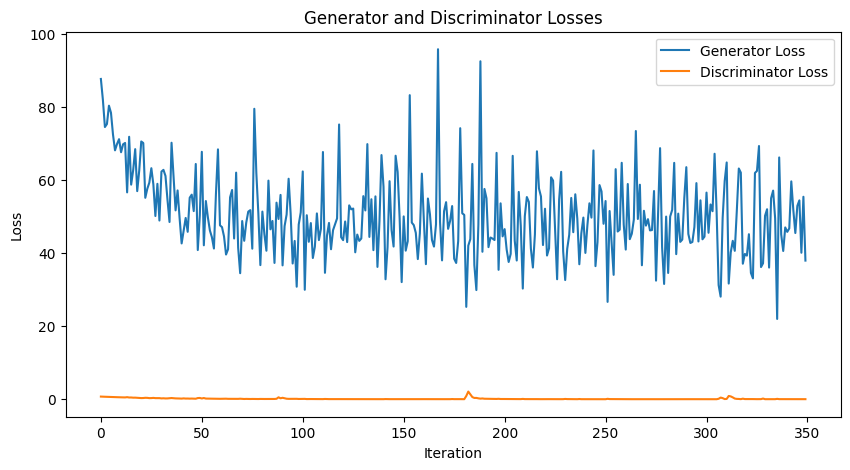

In [8]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Losses")
plt.show()

In [9]:
model_dir = 'models'
pattern = re.compile(r'(?:generator|discriminator)(\d+)\.pth')

# Determine the next model version number
model_files = os.listdir(model_dir)
version_numbers = [int(match.group(1)) for file in model_files if (match := pattern.search(file))]
model_version = max(version_numbers) + 1 if version_numbers else 1

# Save models
torch.save(generator.state_dict(), f'{model_dir}/generator{model_version}.pth')
torch.save(discriminator.state_dict(), f'{model_dir}/discriminator{model_version}.pth')
print(f"Model {model_version} saved to {model_dir}/generator{model_version}.pth and {model_dir}/discriminator{model_version}.pth")

Model 3 saved to models/generator3.pth and models/discriminator3.pth


<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Sample Usage</h1>
</div>

In [10]:
# Redefine the model architectures
generator = UNetGenerator().to(device)
discriminator = PatchDiscriminator().to(device)

# Load weights
generator.load_state_dict(torch.load(f'models/generator{model_version}.pth'))
discriminator.load_state_dict(torch.load(f'models/discriminator{model_version}.pth'))

generator.eval()
discriminator.eval()

PatchDiscriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): Sigmoid()
  )
)

In [11]:
def display_sketch_and_generated(generator, sketch_number, device="cpu"):
    """
    Display the original sketch and the generated clipart side by side.
    
    Parameters
    ----------
        - generator (torch.nn.Module): Trained generator model
        - sketch_number (int): Number of the sketch file (e.g., 2 for 'sketch2.png')
        - device (str): 'cpu' or 'cuda'

    Returns 
    -------
        - None, displays images 

    """
    # Load and transform
    sketch_path = f"data/sketch/sketch{sketch_number}.png"
    sketch = Image.open(sketch_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        ])
    sketch_tensor = transform(sketch).unsqueeze(0).to(device)

    # Generate clipart
    generator.eval()
    with torch.no_grad():
        generated_clipart = generator(sketch_tensor)
        generated_clipart = nn.functional.interpolate(
            generated_clipart, size=(256, 256), mode='bilinear', align_corners=False
        )
        generated_clipart = (generated_clipart.squeeze().cpu() + 1) / 2  # Denormalize to [0, 1]

    # Convert original sketch for plotting
    sketch_for_plot = (sketch_tensor.squeeze().cpu() + 1) / 2  # Denormalize
    sketch_for_plot = np.transpose(sketch_for_plot.numpy(), (1, 2, 0))

    # Convert generated clipart for plotting
    generated_for_plot = np.transpose(generated_clipart.numpy(), (1, 2, 0))

    # Plot
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(sketch_for_plot)
    plt.axis('off')
    plt.title(f"Sketch {sketch_number}")
    
    plt.subplot(1, 2, 2)
    plt.imshow(generated_for_plot)
    plt.axis('off')
    plt.title(f"Generated Clipart {sketch_number}")
    
    plt.show()

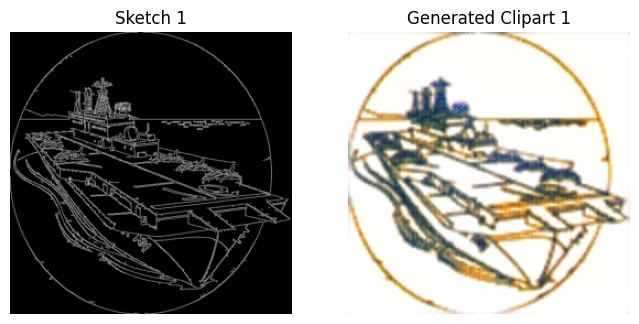

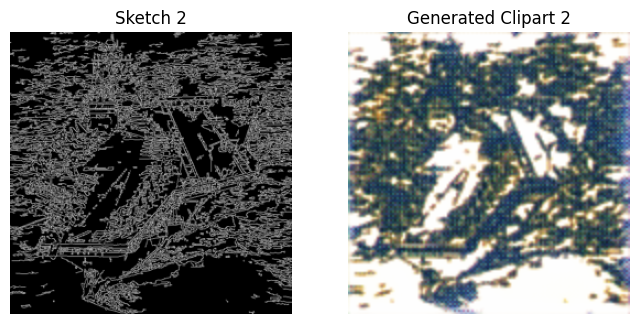

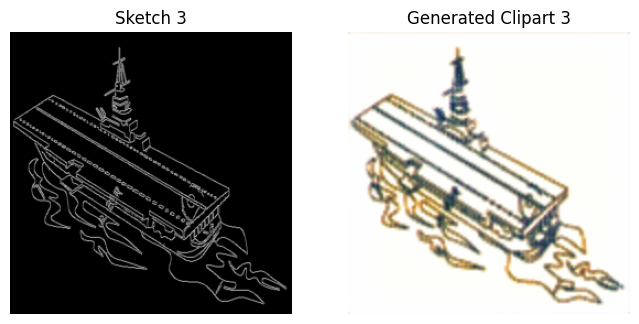

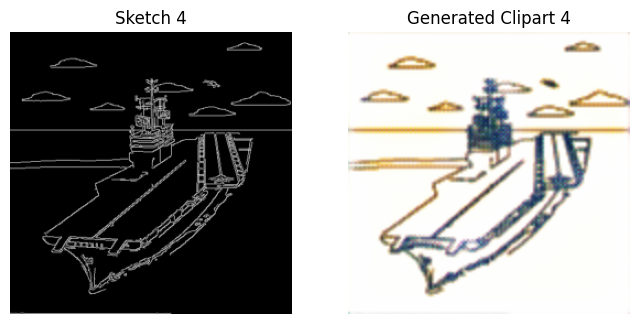

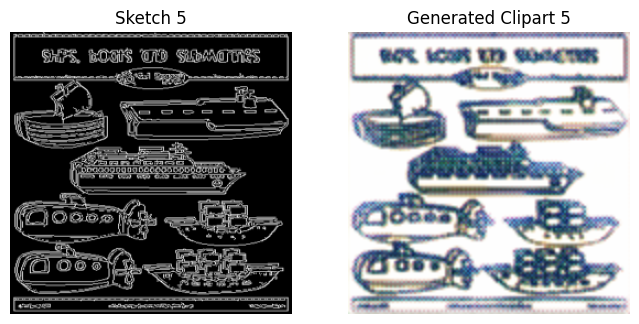

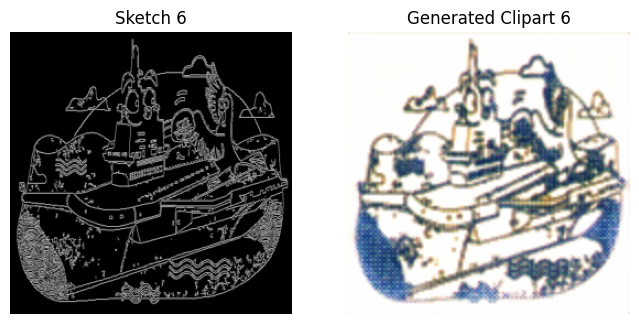

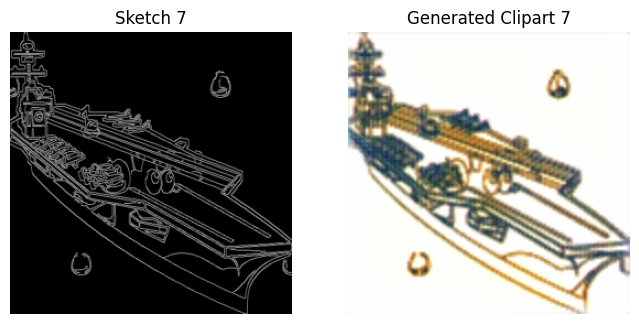

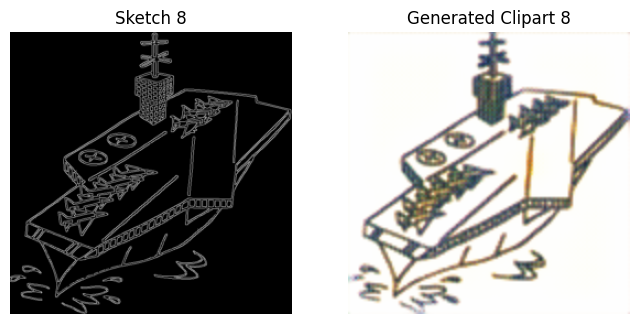

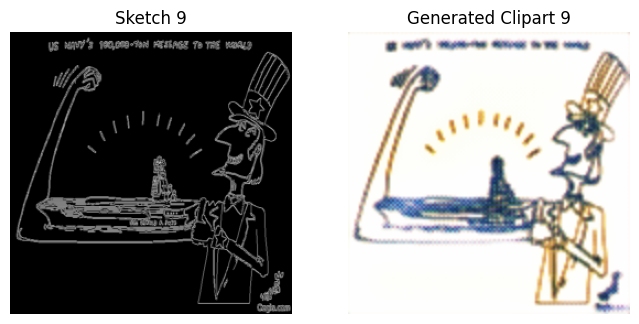

In [12]:
for i in range(1, 10): 
    display_sketch_and_generated(generator, i, device=device)